In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx

class Region:
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def shift_by(self,dx,dy):
        self.x = self.x+dx
        self.y = self.y+dy
    def dis(self,r,dis_method='euclidean'):
        if dis_method=='manhattan':
            return abs(self.x-r.x)+abs(self.y-r.y)
        else:
            return ((self.x-r.x)**2+(self.y-r.y)**2)**0.5

class TimeInterval:
    def __init__(self,b,e):
        self.b = b
        self.e = e
        if(self.b>self.e):
            temp = self.b
            self.b = self.e
            self.e = temp
    def time_intersects(self,time):
        if self.b<=time and time<=self.e:
            return True
        return False

def calc_intention(fear,Q=30,v=0.08):
    return 1.0/(1.0+Q*math.exp(-v*fear))

class Agent:
    def __init__(self, idx, r, beta):
        self.id = idx
        self.region = r
        self.beta = beta #(flee bias beta between [0,1])
        self.fear = 0 #(>0)
        self.intention = calc_intention(self.fear)
        self.migration = 0
        self.migration_time = -1
        self.neighbor_history = []
        
    def update_fear(self,risk,theta=0):
        if self.migration!=1:
            self.fear = self.fear*theta + risk #(theta - discount [0,1])
            self.intention = calc_intention(self.fear)
            self.migration = 0
        else:
            self.fear = 1000000
            self.intention = 1
            self.migration = 1
    
    def reset_agent(self):
        self.fear = 0
        self.intention = calc_intention(self.fear)
        self.migration = 0
        self.migration_time = -1
        self.neighbor_history = []

    def update_migration_from_peer(self,peer_effect,gamma,THRESH):
        tot_weight = gamma*peer_effect+(1-gamma)*self.fear
        if (tot_weight>=THRESH) or self.migration==1:
            self.migration = 1
            if self.migration_time==-1:
                self.migration_time = len(self.neighbor_history)
        else:
            self.migration = 0
            
    def __str__(self):
        all_info = ('agent id:',str(self.id),'current state:',str(self.migration),'loc:',str(self.region.x),',',str(self.region.y))
        return ' '.join(all_info)

class Event:
    def __init__(self, idx, r, w, tint):
        self.event_id = idx
        self.region = r
        self.weight = w
        self.interval = tint
    def happened(self,time):
        if (self.interval).time_intersects(time):
            return True
        return False
    def __str__(self):
        all_info = ('event id:',str(self.event_id),'weight:',str(self.weight),'loc:',str(self.region.x),',',str(self.region.y),'time interval: from',str(self.interval.b),'to',str(self.interval.e))
        return ' '.join(all_info)

def riskfunc(a,E,alpha):
    tot = 0.0
    for event in E:
        #dis = ((a.region).dis(event.region,dis_method='euclidean'))**delta
        dis = np.exp(-(alpha*(a.region).dis(event.region,dis_method='euclidean')))
        #dis = dis+EPS
        cur_fear = (a.beta)*(event.weight)*dis
        tot = tot+cur_fear
    return tot
            

def createplot(Agents,Events,ax,Zoom_Factor=2,Agent_Size=5):
    OFFSET = 0.1
    for a in Agents:
        ax.plot(a.region.x,a.region.y,marker='o',color='blue',markersize=2,
                alpha=0.4)
    for e in Events:
        ax.plot(e.region.x,e.region.y,marker='X',color='red',
                markersize=int(e.weight)*Zoom_Factor)
        #ax.annotate(str(e.event_id), xy =(e.region.x,e.region.y), 
        #     xytext =(e.region.x+OFFSET, e.region.y+OFFSET))
    ax.set_xlim([0,MAX_SCALE])
    ax.set_ylim([0,MAX_SCALE])
    
def create_neighbor_plot(Agents,G,ax,Agent_Size=5):
    for a in Agents:
        for b in Agents:
            if a.id in G.neighbors(b.id):
                ax.plot([a.region.x,b.region.x],[a.region.y,b.region.y],linestyle='--',linewidth=0.5,alpha=0.2,color='black')    

In [2]:
def create_discrete_poisson_process(rate, radius, time_horizon, delta_t=1):
    event_times = np.arange(0, time_horizon, delta_t)
    num_events = np.random.poisson(rate * delta_t, len(event_times))
    all_events = []
    event_id = 0
    for tidx,t in enumerate(event_times):
        event_at_t = num_events[tidx]
        #print(event_at_t)
        for e in range(event_at_t):
            angle = np.random.uniform(0, 2 * np.pi)  # Angle uniformly from [0, 2*pi]
            radial_distance = radius * np.sqrt(np.random.uniform(0, 1))  # Radial distance uniformly within the circle
            # Convert polar coordinates to Cartesian coordinates
            x = radial_distance * np.cos(angle)
            y = radial_distance * np.sin(angle)
            reg = Region(x,y)
            tint = TimeInterval(t,t)
            all_events.append(Event(event_id,reg,1,tint))
            event_id = event_id + 1
    return all_events

def create_random_agents(NUM_AGENTS):
    RANDOM_AGENTS = []
    for i in range(0,NUM_AGENTS):
        cur_id = i
        rand_loc = np.random.rand(1,2).flatten()
        agent_rand_loc = np.random.rand(1,2).flatten()
        agent_r = Region(agent_rand_loc[0]*MAX_SCALE,agent_rand_loc[1]*MAX_SCALE)
        john = Agent(cur_id, agent_r,1)
        RANDOM_AGENTS.append(john)
    return RANDOM_AGENTS


In [3]:
def calc_exp_frac(a,r,tau,gamma,rate,deg):
    ar = a*r
    frac_1_nom = (ar**2)*tau - 2*(1-gamma)*rate*(1-np.exp(-ar)*(1+ar))
    return max(0,min(1,frac_1_nom/((ar**2)*gamma*deg)))

def calc_exp_frac_2(a,r,tau,gamma,rate,deg):
    frac_nom = tau - 2*(1-gamma)*rate
    return max(0,min(1,frac_nom/(gamma*deg)))

def adjust_legend(ax,lgd_params):
    #LEGEND_PARAMS = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,'ecolor':'black','size':12,'alpha':0.2}
    ax.legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
                  handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
                  ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, prop={'size': lgd_params['size']})
    
def evaluate_results(agents,G,alpha,radius,tau,gamma,rate):
    DEL = 0
    degree_dict = dict()
    for aidx, a in enumerate(agents):
        degree_dict[G.degree[aidx]] = [0,0]
    we = 0
    they = 0
    tot = 0
    sq_error_our = 0
    sq_error_naive = 0
    for aidx,a in enumerate(agents):
        if (G.degree[aidx]>0):
            if a.migration_time==-1:
                continue
            theory_val = calc_exp_frac(alpha,radius,tau,gamma,rate,G.degree[aidx])
            fraction_then = a.neighbor_history[a.migration_time+DEL]
            #print('agent ',aidx,'migrated at time',a.migration_time+DEL,'neighbors migrated then was',
                  #round(fraction_then,2),'diff of',round(abs(fraction_then-theory_val),2),'with our derivation and diff of',round(abs(tau/(G.degree[aidx])-fraction_then),2)
                  #,'with naive derivation',end='--')
            sq_error_our = sq_error_our + (fraction_then-theory_val)*(fraction_then-theory_val)
            sq_error_naive = sq_error_naive + (min(1,tau/(G.degree[aidx]))-fraction_then)*(min(1,tau/(G.degree[aidx]))-fraction_then)
            better_est = 'our' if round(abs(fraction_then-theory_val),2)<round(abs(min(1,tau/(G.degree[aidx]))-fraction_then),2) else 'naive'
            tot = tot + 1
            if better_est=='our':
                we = we+1
                degree_dict[G.degree[aidx]][0] = degree_dict[G.degree[aidx]][0] + 1 
            else:
                they = they+1
                degree_dict[G.degree[aidx]][1] = degree_dict[G.degree[aidx]][1] + 1 
            #print(better_est,'method better')
            #adjust_legend(ax[aidx//A_C][aidx%A_C],LEGEND_PARAMS)
    if tot==0:
        return 0.5,-1,-1
    return we/tot,(sq_error_our/tot)**0.5,(sq_error_naive/tot)**0.5

In [4]:
gammas = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
rates = range(30,41)

gamma_x = []
rate_x = []
acc_our_y = []
mse_our_y = []
mse_naive_y = []

In [5]:
import pandas as pd
df = pd.DataFrame(columns=['gamma','rate','seed','acc','mse_our','mse_naive','graph'])

In [6]:
# %%time


# all_dicts = []

# for gamma in gammas:
#     for rate in rates:
#         ## Simulation Parameters
#         SEEDS = range(0,5)
#         for SEED in SEEDS:
#             np.random.seed(SEED)
#             N = 100
#             P = 0.2
#             K = 30
#             M = 11
#             #G = nx.erdos_renyi_graph(N,P,seed=SEED)
#             #G = nx.barabasi_albert_graph(N,M,seed=SEED)
#             G = nx.watts_strogatz_graph(N,K,P,seed=SEED)
#             EPS = 0.00001
#             MAX_SCALE = 10 # space will be within (0,0) -- (10,10)
#             #rate = rate       # Temporal rate (events per unit time)
#             radius = 1     # Radius of the circle
#             time_horizon = 45  # Total number of time steps
#             delta_t = 1      # Time step size
#             alpha = 0.2
#             SIM_TIME = 100
#             #gamma = 0.5
#             tau = 11

#             ## Agents and Events

#             agents = create_random_agents(N)
#             ALL_EVENTS = []
#             for a in agents:
#                 events = create_discrete_poisson_process(rate, radius, time_horizon, delta_t)
#                 for idx in range(len(events)):
#                     events[idx].region.shift_by(a.region.x,a.region.y)
#                 ALL_EVENTS.append(events)

#             ## Simulation Starts

#             ts = []
#             people_migrated = []

#             #tau = 4

#             fixed = -1

#             for a in agents:
#                 a.reset_agent()

#             for t in range(0,SIM_TIME):
#                 #print('at time t',t)
#                 for aidx,a in enumerate(agents):
#                     a_event_set = ALL_EVENTS[aidx]
#                     cur_event_set = []
#                     for e in a_event_set:
#                         if e.happened(t):
#                             cur_event_set.append(e)

#                     risk = riskfunc(a,cur_event_set,alpha)
#                     a.update_fear(risk,0)

#                 temp_neighbor_effects = []

#                 for aidx,a in enumerate(agents):
#                     N_v = G.neighbors(aidx)
#                     peer_effect = sum([agents[v].migration for v in N_v])
#                     temp_neighbor_effects.append(peer_effect)

#                 migrated = 0    
#                 for aidx,a in enumerate(agents):
#                     #print('agent',a.id,'has',round(temp_neighbor_effects[aidx]*gamma,2),'neighbors effect and own impact of',round((1-gamma)*a.fear,2))
#                     a.update_migration_from_peer(temp_neighbor_effects[aidx],gamma,tau)
#                     if G.degree[aidx]>0:
#                         a.neighbor_history.append(temp_neighbor_effects[aidx]/G.degree[aidx])
#                     migrated = migrated + a.migration

#                 ts.append(t)
#                 people_migrated.append(migrated)
#                 if migrated==N and fixed==-1:
#                     fixed = t
#             acc,mse_our,mse_naive = evaluate_results(agents,G,alpha,radius,tau,gamma,rate)
#             print(gamma,rate,acc,mse_our,mse_naive)
#             #print(gamma,rate,evaluate_results(agents,G,alpha,radius,tau,gamma,rate))
#             cur_dict = {'gamma':gamma,'rate':rate,'seed':SEED,'acc':acc,'mse_our':mse_our,'mse_naive':mse_naive,'graph':f'WS_N_{N}_K_{K}_P_{P}'}
#             all_dicts.append(cur_dict)

In [7]:
# cur_dict

In [8]:
# pd.DataFrame.from_dict(all_dicts).to_csv('poisson_result_hi_rate.csv',index=False)

In [9]:
# from matplotlib import rcParams

# #rcParams["font.family"] = "calibri"
# rcParams["font.size"] = 24
# rcParams["axes.labelsize"] = 20
# rcParams["axes.titlesize"] = 20
# rcParams["xtick.labelsize"] = 18
# rcParams["ytick.labelsize"] = 18

# LEGEND_PARAMS = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':1,'ecolor':'black','size':18,'alpha':0.2}

# fig,ax = plt.subplots(1,2,figsize=(8,3))

# for i in range(0,len(gamma_x),len(rates)):
#     print(i)
#     if gamma_x[i]<=0.2:
#         continue
#     if gamma_x[i]>0.5:
#         break
#     xs = rate_x[i:i+len(rates)]
#     ys1 = mse_our_y[i:i+len(rates)]
#     ys2 = mse_naive_y[i:i+len(rates)]
#     ys3 = acc_our_y[i:i+len(rates)]
#     p=ax[0].plot(xs,ys1,label='$\\gamma$='+str(gamma_x[i]),marker='P')
#     #ax[0].p[-1].get_color()
#     ax[0].plot(xs,ys2,color=p[-1].get_color(),marker='X',alpha=0.4)
#     ax[1].plot(xs,ys3,label='$\\gamma$='+str(gamma_x[i]))

# for i in range(0,2):
#     if i==0:
#         continue
#     adjust_legend(ax[i],LEGEND_PARAMS)
    
# ax[0].set_xlabel('$\\lambda_t$')
# ax[1].set_xlabel('$\\lambda_t$')
# #ax[2].set_xlabel('$\\lambda_t$')

# ax[0].set_ylabel('MSE')
# ax[1].set_ylabel('Acc. Ratio')
# #ax[2].set_ylabel('$\\lambda_t$')
    
# ax[0].set_ylim([0,None])
# ax[1].set_ylim([None,1.05])
# #ax[2].set_ylim([None,1.05])
# # ax[0].legend(loc='best')
# # ax[1].legend(loc='best')
# # ax[2].legend(loc='best')
# fig.tight_layout()
# fig.savefig('neighbor_fraction_capture_mid_gamma.pdf',dpi=350,bbox_inches='tight')

In [10]:
%%time
SEED = 1
np.random.seed(SEED)
N = 100 #100
P = 0.2
K = 30 #30
M = 11 #11
#G = nx.erdos_renyi_graph(N,P,seed=SEED)
G = nx.barabasi_albert_graph(N,M,seed=SEED)
#G = nx.watts_strogatz_graph(N,K,P,seed=SEED)
EPS = 0.00001
MAX_SCALE = 10 # space will be within (0,0) -- (10,10)
rate = 16   #16  # Temporal rate (events per unit time)
radius = 1     # Radius of the circle
time_horizon = 45  # Total number of time steps
delta_t = 1      # Time step size
alpha = 0.2
SIM_TIME = 100
gamma = 0.6
tau = 11

## Agents and Events

agents = create_random_agents(N)
ALL_EVENTS = []
for a in agents:
    events = create_discrete_poisson_process(rate, radius, time_horizon, delta_t)
    for idx in range(len(events)):
        events[idx].region.shift_by(a.region.x,a.region.y)
    ALL_EVENTS.append(events)

## Simulation Starts

ts = []
people_migrated = []

#tau = 4

fixed = -1

for a in agents:
    a.reset_agent()

for t in range(0,SIM_TIME):
    #print('at time t',t)
    for aidx,a in enumerate(agents):
        a_event_set = ALL_EVENTS[aidx]
        cur_event_set = []
        for e in a_event_set:
            if e.happened(t):
                cur_event_set.append(e)

        risk = riskfunc(a,cur_event_set,alpha)
        a.update_fear(risk,0)

    temp_neighbor_effects = []

    for aidx,a in enumerate(agents):
        N_v = G.neighbors(aidx)
        peer_effect = sum([agents[v].migration for v in N_v])
        temp_neighbor_effects.append(peer_effect)

    migrated = 0    
    for aidx,a in enumerate(agents):
        #print('agent',a.id,'has',round(temp_neighbor_effects[aidx]*gamma,2),'neighbors effect and own impact of',round((1-gamma)*a.fear,2))
        a.update_migration_from_peer(temp_neighbor_effects[aidx],gamma,tau)
        if G.degree[aidx]>0:
            a.neighbor_history.append(temp_neighbor_effects[aidx]/G.degree[aidx])
        migrated = migrated + a.migration

    ts.append(t)
    people_migrated.append(migrated)
    if migrated==N and fixed==-1:
        fixed = t

CPU times: user 3.47 s, sys: 18.5 ms, total: 3.49 s
Wall time: 3.59 s


In [11]:
print(ts)
print(people_migrated)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 7, 8, 10, 11, 14, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]


In [12]:
# for aidx, a in enumerate(agents):
#     theory_val = calc_exp_frac(alpha,radius,tau,gamma,rate,G.degree[aidx])
#     print(theory_val)

## Environment Visualization

0


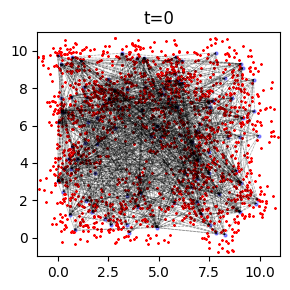

In [13]:
DIV_R = 1
DIV_C = 1
fig,ax = plt.subplots(DIV_R,DIV_C,figsize=(3*DIV_C,3*DIV_R),squeeze=False)

EVENTS_THROUGH_TIME = []

for tidx in range(DIV_R*DIV_C):
    print(tidx)
    cur_event_set = []
    for agent_event_set in ALL_EVENTS:
        for e in agent_event_set:
            if e.happened(tidx):
                cur_event_set.append(e)
    EVENTS_THROUGH_TIME.append(cur_event_set)
    createplot(agents,cur_event_set,ax[tidx//DIV_C][tidx%DIV_C],Zoom_Factor=1)
    ax[tidx//DIV_C][tidx%DIV_C].set_title('t='+str(tidx))
    ax[tidx//DIV_C][tidx%DIV_C].set_xlim([-1,11])
    ax[tidx//DIV_C][tidx%DIV_C].set_ylim([-1,11])
    create_neighbor_plot(agents,G,ax[tidx//DIV_C][tidx%DIV_C])
fig.tight_layout()
#fig.savefig('WS-env-poison-small.pdf',dpi=350,bbox_inches='tight')

In [14]:
#print(len(EVENTS_THROUGH_TIME)) #with respect to time

In [15]:
#print(len(ALL_EVENTS)) #with respect to agents

## Result Visualization

In [16]:
if fixed!=-1:
    fixed = min(len(ts)-2,fixed + 2)

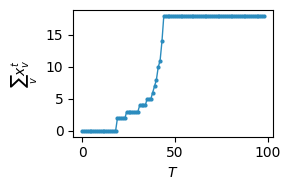

In [17]:
fig,ax = plt.subplots(figsize=(3,2))
ax.plot(ts[0:fixed],people_migrated[0:fixed],marker='o',linewidth=1,markersize=2,color='#2b8cbe')
ax.set_xlabel('$T$')
ax.set_ylabel('$\\sum_v{x_v^t}$')
fig.tight_layout()

In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# #import scienceplots  # noqa: F401

# import os

# # Check we are in examples dir
# current_dir = os.getcwd().lower()
# if current_dir.endswith("scienceplots"):
#     os.chdir("./examples")
# # Create 'figures' folder if it does not exist
# if not os.path.exists("./figures"):
#     os.makedirs("figures")


# def model(x, p):
#     return x ** (2 * p + 1) / (1 + x ** (2 * p))


# pparam = dict(xlabel="Voltage (mV)", ylabel=r"Current ($\mu$A)")

# x = np.linspace(0.75, 1.25, 201)


# fig, ax = plt.subplots()
# for p in [10, 15, 20, 30, 50, 100]:
#     ax.plot(x, model(x, p), label=p)
# ax.legend(title="Order")
# ax.autoscale(tight=True)
# ax.set(**pparam)
# #fig.savefig("figures/fig01a.jpg", dpi=300)
# #plt.close()

18
agent  0 migrated at time 43 neighbors migrated then was 0.17 diff of 0.02 with our derivation 0.18724337437308997  and diff of 0.06 with naive derivation 0.22916666666666666--our method better
agent  11 migrated at time 38 neighbors migrated then was 0.15 diff of 0.12 with our derivation 0.26434358735024466  and diff of 0.18 with naive derivation 0.3235294117647059--our method better
agent  13 migrated at time 43 neighbors migrated then was 0.16 diff of 0.02 with our derivation 0.18342208101853713  and diff of 0.06 with naive derivation 0.22448979591836735--our method better


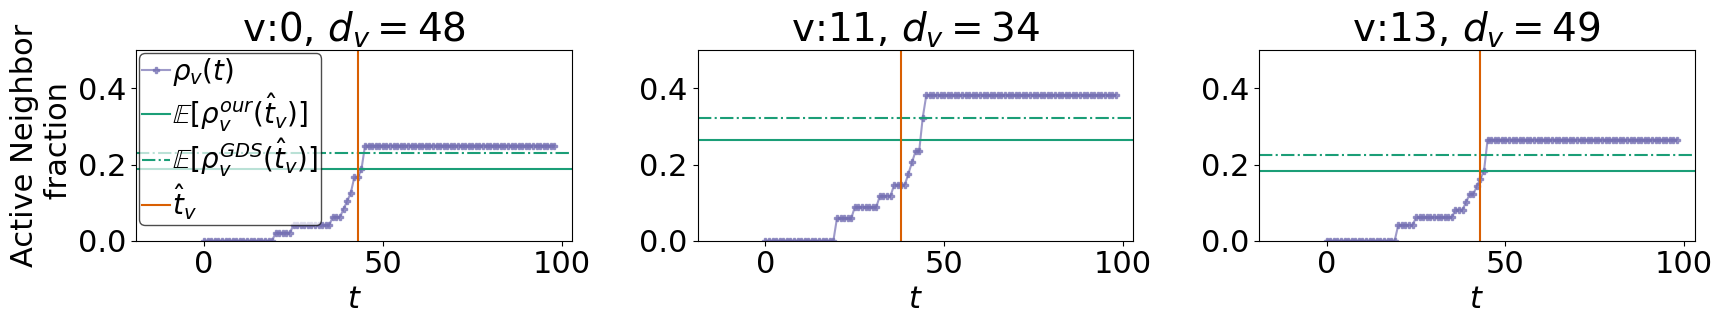

In [25]:
from matplotlib import rcParams

#rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 22
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 22
rcParams["ytick.labelsize"] = 22

LEGEND_PARAMS = {'hlen':1,'bpad':0.1,'lspace':0.1,'htxtpad':0.1,'baxpad':0.1,'cspace':0.1,'ncol':1,'ecolor':'black','size':20,'alpha':0.7}

we = 0
they = 0

DEL = 0

degree_dict = dict()
for aidx, a in enumerate(agents):
    degree_dict[G.degree[aidx]] = [0,0]

migrated_agents = []
migrated_agents_idx = []

for aidx,a in enumerate(agents):
    if (a.migration_time==-1) or G.degree[aidx]<=0:
        continue
    migrated_agents.append(a)
    migrated_agents_idx.append(aidx)
print(len(migrated_agents))

A_R = 1
A_C = 3

fig,ax = plt.subplots(A_R,A_C,figsize=(6*A_C,4*A_R),squeeze=False)
for maidx,a in enumerate(migrated_agents):
    if maidx==3:
        break
    aidx = migrated_agents_idx[maidx]
    ax[maidx//A_C][maidx%A_C].set_title('v:'+str(aidx)+', $d_v=$'+str(G.degree[aidx]))
    ax[maidx//A_C][maidx%A_C].set_xlabel('$t$')
    if maidx==0:
        ax[maidx//A_C][maidx%A_C].set_ylabel('Active Neighbor\n fraction')
    if (G.degree[aidx]>0):
        if a.migration_time==-1:
            continue
        ax[maidx//A_C][maidx%A_C].plot(ts[0:fixed],a.neighbor_history[0:fixed],label='$\\rho_v(t)$',alpha=0.7,marker='P',markersize=5,color='#7570b3')
        theory_val = calc_exp_frac(alpha,radius,tau,gamma,rate,G.degree[aidx])
        ax[maidx//A_C][maidx%A_C].axhline(theory_val,label='$\\mathbb{E}[\\rho^{our}_v(\hat{t}_v)]$',color='#1b9e77')
        ax[maidx//A_C][maidx%A_C].axhline(tau/(G.degree[aidx]),label='$\\mathbb{E}[\\rho^{GDS}_v(\hat{t}_v)]$',linestyle='dashdot',color='#1b9e77')
        #ax[aidx//A_C][aidx%A_C].axhline(theory_thresh_2,label='$\\rho_c^2$',linestyle='--')
        ax[maidx//A_C][maidx%A_C].axvline(a.migration_time+DEL,label='$\\hat{t}_v$',linestyle='-',color='#d95f02')
        ax[maidx//A_C][maidx%A_C].set_ylim([0,0.5])
        ax[maidx//A_C][maidx%A_C].set_xlim([-19,None])
        fraction_then = a.neighbor_history[a.migration_time+DEL]
        print('agent ',aidx,'migrated at time',a.migration_time+DEL,'neighbors migrated then was',
              round(fraction_then,2),'diff of',round(abs(fraction_then-theory_val),2),'with our derivation',theory_val,' and diff of',round(abs(tau/(G.degree[aidx])-fraction_then),2)
              ,'with naive derivation',tau/G.degree[aidx],end='--')
        better_est = 'our' if round(abs(fraction_then-theory_val),2)<round(abs(tau/(G.degree[aidx])-fraction_then),2) else 'naive'
        if better_est=='our':
            we = we+1
            degree_dict[G.degree[aidx]][0] = degree_dict[G.degree[aidx]][0] + 1 
        else:
            they = they+1
            degree_dict[G.degree[aidx]][1] = degree_dict[G.degree[aidx]][1] + 1 
        print(better_est,'method better')
        if maidx==0:
            adjust_legend(ax[maidx//A_C][maidx%A_C],LEGEND_PARAMS)
fig.tight_layout()
fig.savefig('Figures/sample_ba_experiment.pdf',dpi=350,bbox_inches='tight')

In [42]:
migrated_agents_idx

[0, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 39, 51, 69, 93]

In [26]:
print(we/(we+they))

0.9444444444444444


In [29]:
# fig,ax = plt.subplots(figsize=(8,5))
# xs1 = [a.neighbor_history[a.migration_time] for aidx, a in enumerate(agents) if G.degree[aidx]>0]
# ys1 = [calc_exp_frac(alpha,radius,tau,gamma,rate,G.degree[aidx]) for aidx, a in enumerate(agents) if G.degree[aidx]>0]
# ys2 = [tau/G.degree[aidx] for aidx, a in enumerate(agents) if G.degree[aidx]>0]


# ax.scatter(xs1,ys2,label='GDS (No SBP)')
# ax.scatter(xs1,ys1,label='GDS (SBP)')
# ax.scatter(xs1,xs1,color='gray')
# ax.set_xlim([0,1])
# ax.set_ylim([0,1])
# ax.legend(loc='best',fontsize=12)

<!-- Keep n fixed construct a curve
that shows for each different p, 
x axis t
y axis percentage of people migrating -->